# Simulation Adiabatic Theorem

In this notebook, we run a simulation and present the numerical program used for the final project in the advanced quantum course, focusing on the *Adiabatic Theorem*. The simulation explores the adiabatic evolution of a harmonic oscillator transitioning from an initial Hamiltonian, $\mathcal{H}{0}$, with a frequency $\omega{0}$ to a final Hamiltonian, $\mathcal{H}{f}$, with a frequency $\omega{f}=3\omega_{0}$. The general expression for the Hamiltonian is given by:

$$\mathcal{H}(t)=\frac{p}{2m}+\frac{m\omega^{2}(t) x^{2}}{2}.$$

We investigate adiabatic evolution under two different cases, each with a distinct function $\omega(t)$, where, in all cases, $\omega(t=0)=\omega_{0}$ and $\omega(t=t_{f})=\omega_{f}$. Additionally, we explore the diabatic limit, involving an instantaneous transition from $\mathcal{H}{0}$ to $\mathcal{H}{f}$, aiming to compare the differences in both limits.

However, in this notebook, we specifically focus on the short-cut adiabatic case to enhance code accessibility for non-programmers and avoiding enfuriating more experimented programmers with the non-optimized code. The selected function for this case is: 

$$\omega^{2}(t)=\frac{\omega_{0}}{b^{4}(t)}-\frac{\ddot{b}(t)}{b(t)}.$$

Here, $b(t)$ is the function which carries all the time  dependence and has the form 

$$b(t)=6(\gamma-1)^{5}-15(\gamma-1)s^{4}+10(\gamma-1)s^{3}+1,$$

where $\gamma=\sqrt{\frac{\omega_{0}}{\omega_{f}}}$ and $s=\frac{t}{t_{f}}$.

First, we import all the necessarie python libraries that we will use for our program.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import math as mt
from scipy import integrate as inte
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
pi=mt.pi

## Split-step method functions:

The time evolution of a wave function is described by the equation

$$\psi(t+dt,x)=e^{-\frac{i(\hat{T}+\hat{V}(x))dt}{\hbar}}\psi(t,x),$$

where $\hat{T}$ is the kinetic operator and $\hat{V}(x)$ is the potential operator. These operators can be represented in either momentum space or position space as follows

$$\begin{matrix}
&\textbf{Position space (x):} & \textbf{momentum space (p):} \\
& e^{-\frac{idt}{\hbar}V} \rightarrow e^{-\frac{idt}{\hbar}V(x)}, & e^{-\frac{idt}{\hbar}V} \rightarrow e^{-\frac{idt}{\hbar} V(i\hbar\frac{\partial}{\partial p} )},\\ 
& e^{-\frac{idt}{\hbar}T} \rightarrow e^{\frac{i\hbar dt}{2m}\frac{\partial^2}{\partial x^2}}, & e^{-\frac{idt}{\hbar}T} \rightarrow e^{-\frac{idt}{\hbar}\frac{p^2}{2m}},
\end{matrix}$$

The problem is that the $ T $ and $ V $ operators do not commute, so we can not calculate each termindepently in their diagonal space. This is where split-step methods prove useful. These methods aim to avoid the non-commutative issue by approximating

$$e^\lambda(A+B) \approx e^{\lambda\beta_{n}B}e^{\lambda\alpha_{n}A}\hspace{0,01cm}...\hspace{0,1cm} e^{\lambda\beta_{1}B}e^{\lambda \alpha_{1}A}.$$

The philosophy behind split-operator methods lies in selecting coefficients $\alpha_i$ and $\beta_i$  so the right-hand part of the equation approximates the left side to the desired order in $\lambda$.

For our case an error of  $\mathcal{O}(\lambda^3)$ is enough, so the respectively coefficients are $\alpha_1=\alpha_2=\frac{1}{2}$ and $\beta_1=1 $. Hence the last equation can be writte as

$$\psi(t+dt,x)= [e^{\frac{-idt}{2\hbar} V(x)} e^{-\frac{idt}{\hbar}T} e^{\frac{-idt}{2\hbar} V(x)}]\psi(t,x)+\mathcal{O}(\lambda^3).$$

As mentioned earlier, the exponential operators in their respective spaces correspond to scalars in $1D$. Exploiting the Fourier properties, the simplest and most direct method to compute it would be:


$$\psi_{0}(x) = \psi(t_{0},x),$$
$$\psi_{1}(p) = \mathcal{F}[e^{\frac{-idt}{2\hbar} V(x)}\psi_{0}(x)]$$
$$\psi_{2}(x) = \mathcal{F}^{-1}[e^{-\frac{idt}{\hbar}\frac{p^2}{2m}}\psi_{1}(p)],$$
$$\psi(t_{0}+dt,x) = e^{\frac{-idt}{2\hbar} V(x)}\psi_{2}(x).$$


The following functions correspond to all the necessary intermediate steps to achieve the Split-step evolution. For more information abouth the Split-step method, there is a really nice package and mathematically description in: https://www.algorithm-archive.org/contents/split-operator_method/split-operator_method.html

In [3]:
#______________________________________________________________________________
#Transformed domain points:
#given an initial space domain points, the points in the transformed domain 
#space are calculated.

#arguments:
#x: N initial points x of the initial space
#N: number of points used
#dx:space between points in the initial domain

#outputs:
#k:N corresponding points in the transformed space
#dk:distance between points in the transformed domain

def trans_space(N,x,dx):
    #critic freq.
    kc=1/(2*dx)
    #space between point in transform space
    dk=1/(N*dx)
    #points in transform space
    k=np.linspace(-kc,kc-dk,N)
    return k,dk




#______________________________________________________________________________
#FT routine:
#given a initial function (f) and the corresponding space points (x) returns the
#FT(f) and the corresponding points in the transformed space domain (k).

#arguments:
#gx: function g(x) sampled with N points
#dx:space between points in the initial domain

#outputs:
#FTgk: FT(g(x)) sampled with N points


def fourier_trans(gx,dx):
    #calculate FT
    FTgk=np.fft.fftshift(fft(gx))*dx
    return FTgk





#______________________________________________________________________________
#IFT routine
#given a initial function (f) and the corresponding space points (x) returns the
#IFT(f) and the corresponding points in the transformed space domain (k).
#arguments:
#gk: function g(k) sampled with N points
#dx:not use dk, if you want to use dk you also have to multiply by N, but i prefer
#to not use N because it is more arguments than the strictly necessary

#outputs:
#IFTgx: IFT(g(k)) sampled with N points

def inv_fourier_trans(gk,dx):
    IFTgk=ifft(np.fft.ifftshift(gk))*1/dx
    return IFTgk




#________________________________________________________________________________
#Psi 1 in the x space:
#calculate the first psi of the method in the x domain-

#inputs:
#Vx:vector of N points with the values of the external potential in x space
#g:couple constant of the non linear term
#psi0x: vector with n points corresponding to the initial wavefunction at time t
#in the initial x space
#dt: interval betwen t+dt and t

#outputs:
#psi1x: new wavefunction in the x space




def psi_onex(Vx,g,psi0x,dt):
    #prepare the value complex j:
    j=complex(0,1)
    #exponent of the exponential
    expon=-(j*dt*Vx/2.0)+g*np.abs(psi0x)*np.abs(psi0x)
    #calculate the e^expon
    expterm=np.exp(expon)
    #aply the exponential to psi0x to obtein the new wave function
    psi1x=expterm*psi0x
    return psi1x


#________________________________________________________________________________

#Important to know:
#Important to be aware here that our k is not really the wave number, where here 
# due to our special units (hbarra=1) wavenumber(wavenum) corresponds directly 
#to momentum because wavenum=p/hbarra. But here k*2pi=wavenum, this is because 
#our k would represent more the invere longth wave, but this is not important


#psi2p:
#psi 2 in the transformed domain k

#inputs:
#k:vector of N points with the values of the k points in the k domain
#psi1p: vector with n points corresponding to the wavefunction 1 in the p domain
#dt: interval betwen t+dt and t

#outputs:
#psi2p:wave function psi 2 in the p domain

def psi_twop(k,psi1p,dt):
    #prepare pi and j values
    pi=mt.pi
    j=complex(0,1)
    #calculate the momentum vector
    p=2*pi*k
    #calculate the exponent value
    expon=-j*dt*p*p/2.0
    #calculate the exponential
    expterm=np.exp(expon)
    #aply the exponential to the initial wave function
    psi2p=expterm*psi1p
    return psi2p





#______________________________________________________________________________
#psi(t+dt)x: calculate function psi in the time t+dt in the x space

#inputs:
#Vx:vector of N points with the values of the external potential in x space
#g:couple constant of the non linear term
#psi0x: vector with n points corresponding to psi0 in the x space
#psi1x: vector with n points corresponding to psi1 in the x space
#psi2x: vector with n points corresponding to psi2 in the x space


#outputs:
#psifx:function psi in the time t+dt in the x space

def psi_fx(Vx,g,psi0x,psi1x,psi2x,dt):
    #prepare the value complex j:
    j=complex(0,1)
    #exponent of the exponential
    mod0=np.abs(psi0x)*np.abs(psi0x)
    mod1=np.abs(psi1x)*np.abs(psi1x)
    mod2=np.abs(psi2x)*np.abs(psi2x)
    expon=-(j*dt*Vx/2.0)+g*(mod0-mod1+mod2)
    #calculate the e^expon
    expterm=np.exp(expon)
    #aply the exponential to psi0x to obtein the new wave function
    psifx=expterm*psi2x
    return psifx


#_____________________________________________________________________________
#SPLIT_STEP method:
#from an initial wave function psi(t,x) the split step method wil return the 
#wave function psi(t+dt,x)

#input:
#N:number of points will be used
#x: vector of N points, corresponding to the space values x where psi is calculated
#dx:space between the x points
#psi0:N point vector with the corresponding values of the wave funct. in some x
#dt: interval of time betwen t and t+dt
#Vx:values of the external potential
#g:coupled parameter
#output:
#psifx:the wave function in time dt+t 

def split_step(N,x,dx,psi0x,dt,Vx,g,k,dk):

    #calculate the psi1x
    psi1x=psi_onex(Vx,g,psi0x,dt)
    #Transform psi1x to the momentum space with FT
    psi1p=fourier_trans(psi1x,dx)
    #now calculate the psi2p:
    psi2p=psi_twop(k,psi1p,dt)
    #get psi2x with the inverse fourier transform
    psi2x=inv_fourier_trans(psi2p,dx)
    #now get the final psifx:
    psifx=psi_fx(Vx,g,psi0x,psi1x,psi2x,dt)
    return psifx

### Hamonic oscillator:

The simulation involves initiating from the ground state or the $n=0$ state of $\mathcal{H}{0}$ and demonstrating that through adiabatic evolution, the state arrive to the $n=0$ state of $\mathcal{H}{f}$. To verify the correct attainment of the eigenstate of $\mathcal{H}{f}$, we have computed the dispersion $\sigma^{2}{x}$ and the density probability $|\phi(x,t)|^{2}$ at each time step.

The time evolution is divided into two segments. The first segment goes from $t=0$ to $t=t_{f}$ and corresponds to the adiabatic evolution. In the second segment, the system evolves using $\mathcal{H}{f}$ from $t=t{f}$ to $t=2t_{f}$. This last part serves as a test to confirm if we have really reached an eigenstate.

In [4]:
def freq_oscillator(s,w_init,w_fin,tf):
    gamma=np.sqrt(w_init/w_fin)
    coef_adia=6.*(gamma-1)*s**5 -15*(gamma-1)*s**4 +10*(gamma-1)*s**3 +1
    der_coef_adia=(6.*20*(gamma-1)*s**3 -15*12*(gamma-1)*s**2 +10*6*(gamma-1)*s)*(1/tf)**2
    frec_square=((w_init)**2/coef_adia**4)-(der_coef_adia/coef_adia)
    w_t=np.sqrt(frec_square)
    return w_t

#### Step1:

Now we are actually starting the simulation. 

Firstly, we establish the mesh upon which we will evaluate and construct our physical system. For this simulation, we have created a spatial mesh (along the $x$ coordinate) with $N=2^{15}$ points, covering a range from $-6$ to $6$.

The following step involves computing the mesh for the reciprocal space or momentum space ($k$ coordinate) using the trans_space function. In addition, for the time evolution, we employ $N_{t}=10000$ steps, with time ranging from $0$ to $t_{f}=20$ using a time step of $\Delta t=0.0001t_{f}$.

All physical units are normalized to $\mathcal{H}{0}$; numerically, this entails $m=1$, $\hbar=1$, and $\omega{0}=1$.

As previously mentioned, the initial wave function is the ground state of $\mathcal{H}{0}$. We have also computed the ground state and the first two excited states of $\mathcal{H}{f}$ to assess their contributions to the final wave function $\psi(x,t_{f})$. If the adiabatic evolution has been executed correctly, the only non-zero contribution should arise from the ground state.









In [6]:
#form the x space grind
N=2**15
x=np.linspace(-6,6,N)
L=x[N-1]-(x[0])
dx=L/N

#Calculate the k points and the dk with trans space:
k,dk=trans_space(N,x,dx)

#time grind:
Nt=10000
s1=np.linspace(0.0001,1,Nt)
ds=s1[1]-s1[0]
tf=20
dt=ds*tf
s2=np.linspace(1.0001,2,Nt)
#physical units
w_init=1.
m_osc=1.
hbar=1.
g=0.
w_fin=3.

#Vx: potential correspont to 1/2 w^2 x^2
Vx=(x*x)*(1/2.0)*w_init**2

#inital wave function:
#x space
C_init=mt.sqrt(mt.sqrt(m_osc*w_init/(pi*hbar)))
x0=0.
exponent=(x-x0)*(x-x0)*m_osc*w_init/(hbar*2)
psi0x=np.exp(-exponent)*C_init
probx=np.abs(psi0x)**2
norm=inte.simps(probx,x,dx)

# k space
psi0k=np.fft.fftshift(fft(psi0x))*dx
probx=np.abs(psi0x)**2
probk=np.abs(psi0k)**2


#eigen states 1 and 2 from the final Hamiltonian Hf
a_eigen=np.sqrt(1./3.)

norm_eigen=np.sqrt(np.sqrt(1./(pi*(a_eigen**2))))

numc_eigen0=1.
numc_eigen1=np.sqrt(1./2.)
numc_eigen2=np.sqrt(1./2.**3)

exponent=-(1./2.)*(x/a_eigen)**2

Hermit0=1.*np.ones(np.shape(x))
Hermit1=2.*x/a_eigen
Hermit2=4.*(x/a_eigen)**2-2.*np.ones(np.shape(x))

final_eigen0=norm_eigen*numc_eigen0*Hermit0*np.exp(exponent)
Norm_eig0=np.sqrt(inte.simps(final_eigen0**2,x,dx))
final_eigen0=final_eigen0/Norm_eig0
final_eigen1=norm_eigen*numc_eigen1*Hermit1*np.exp(exponent)
Norm_eig1=np.sqrt(inte.simps(final_eigen1**2,x,dx))
final_eigen1=final_eigen1/Norm_eig1
final_eigen2=norm_eigen*numc_eigen2*Hermit2*np.exp(exponent)
Norm_eig2=np.sqrt(inte.simps(final_eigen2**2,x,dx))
final_eigen2=final_eigen2/Norm_eig2


#Expected values for x and p, x^2 and p^2
Ix=inte.simps(x*probx,x,dx)
Ip=inte.simps(2*pi*k*probk,k,dk)
Ixquadr=inte.simps(x*x*probx,x,dx)
Ipquadr=inte.simps(((2*pi*k)**2)*probk,k,dk)


#In order to do the animation, in different times the wave function will be 
#saved in the y variable. Also we will save the time corresponding to each wave 
#function.

prob_t=[]
x_mean=[]
xquadrat_mean=[]
p_mean=[]
pquadrat_mean=[]
s_tot=[]
potential_t=[]

### Step 2: Temporal evolution block 1

The above cell is the adiabatic evolution using the Split-step method. At each time we also compute the expected value of $<x>$ and $<x^{2}>$. Finally we compute the bracket with the different eigenstates from $\mathcal{H}_{f}$, as we expected, the only none-zero contribution is from the ground state.

In [5]:
#apply step method evolution
count=0
for i in s1:
    #compute the new time
    s_tot.append(i)
    w_t=freq_oscillator(i,w_init,w_fin,tf)
    Vx=(x*x)*(1/2.0)*(w_t)**2
    potential_t.append(Vx)
    legen='s='+str(i)
    psifx=split_step(N,x,dx,psi0x,dt,Vx,g,k,dk)
    psifk=np.fft.fftshift(fft(psifx))*dx
    probx=np.abs(psifx)**2
    probk=np.abs(psifk)**2
    Norm_x=np.sqrt(inte.simps(probx,x,dx))
    Norm_k=np.sqrt(inte.simps(probk,k,dk))
    psifx=psifx/Norm_x
    psifk=psifk/Norm_k
    probx=np.abs(psifx)**2
    probk=np.abs(psifk)**2
    Ix=inte.simps(x*probx,x,dx)
    Ip=inte.simps(2*pi*k*probk,k,dk)
    Ixquadr=inte.simps(x*x*probx,x,dx)
    Ipquadr=inte.simps(((2*pi*k)**2)*probk,k,dk)
    x_mean.append(Ix)
    p_mean.append(Ip)
    xquadrat_mean.append(Ixquadr)
    pquadrat_mean.append(Ipquadr)
    psi0x=np.copy(psifx)
    count+=1
    prob_t.append(probx[8191:24576])
    residuo=count%1000
    if residuo==0:
        print(i)


escalar_prod0=np.abs(inte.simps(final_eigen0*np.abs(psi0x),x,dx))
escalar_prod1=np.abs(inte.simps(final_eigen1*np.abs(psi0x),x,dx))
escalar_prod2=np.abs(inte.simps(final_eigen2*np.abs(psi0x),x,dx))

print('Escalar product between tf and n=0 from Hf:',escalar_prod0)
print('Escalar product between tf and n=1 from Hf:',escalar_prod1)
print('Escalar product between tf and n=2 from Hf:',escalar_prod2)



0.1
0.2
0.3
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
Escalar product between tf and n=0 from Hf: 0.9999999997900477
Escalar product between tf and n=1 from Hf: 2.7755575615628914e-14
Escalar product between tf and n=2 from Hf: 2.0491584027528098e-05


### Step 2: Temporal evolution block 2

The above cell is the standard time evolution using the Split-step method. At each time we also compute the expected value of $<x>$ and $<x^{2}>$. 

In [6]:
count=0
#apply step method evolution
for i in s2:
    s_tot.append(i)
    Vx=(x*x)*(1/2.0)*(w_t)**2
    potential_t.append(Vx)
    legen='s='+str(i)
    psifx=split_step(N,x,dx,psi0x,dt,Vx,g,k,dk)
    psifk=np.fft.fftshift(fft(psifx))*dx
    probx=np.abs(psifx)**2
    probk=np.abs(psifk)**2
    Norm_x=np.sqrt(inte.simps(probx,x,dx))
    Norm_k=np.sqrt(inte.simps(probk,k,dk))
    psifx=psifx/Norm_x
    psifk=psifk/Norm_k
    probx=np.abs(psifx)**2
    probk=np.abs(psifk)**2
    prob_t.append(probx[8191:24576])
    Ix=inte.simps(x*probx,x,dx)
    Ip=inte.simps(2*pi*k*probk,k,dk)
    Ixquadr=inte.simps(x*x*probx,x,dx)
    Ipquadr=inte.simps(((2*pi*k)**2)*probk,k,dk)
    x_mean.append(Ix)
    p_mean.append(Ip)
    xquadrat_mean.append(Ixquadr)
    pquadrat_mean.append(Ipquadr)
    psi0x=np.copy(psifx)
    count+=1
    residuo=count%1000
    if residuo==0:
        print(i)



1.1
1.2
1.3
1.4
1.5
1.6
1.7000000000000002
1.8
1.9
2.0


### Step 3: Results

##### Finally we can plot all the results from our simulation!

In the initial plot, we can observe the density distribution $|\psi(x, t)|^2$ represented as a color map for each time and position. It is evident that during the adiabatic evolution (up to reaching $s=1$), our wave function gets narrower. This narrowing is a consequence of the gradual increase in our potential, allowing the wave function to adapt to the new ground state, which is narrow due to the higher values of the potential function. At $s=1$, we have reached the ground state of $\mathcal{H}_{f}$. Since this new function is an eigenstate, the density probability remains unchanged over time.

In the second plot we can appreciate a similar phenomena than the previous case. Specifically, it can be stated that $\sigma^{2}_{x}(t)$ undergoes a decrease during the adiabatic evolution until it reaches $\sigma^{2}{x}(t_{f})$ at $s=1$. From this point, we have attained the groundstate, hence the $\sigma^{2}_{x}(t)$ remains constant in time.

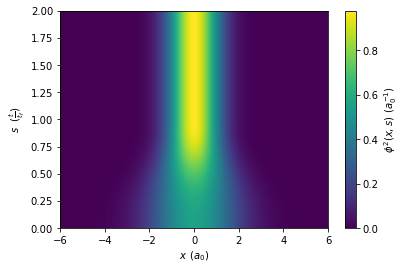

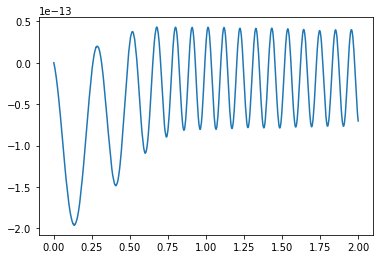

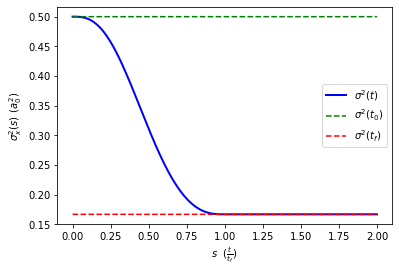

In [7]:
import matplotlib.pyplot as plt

# Your existing code
extent = (-6, 6, 0, 2)
prob_t2 = prob_t[::-1]
plt.imshow(prob_t2, extent=extent, aspect='auto')
plt.xlabel(r'$ x \:\: (a_{0})$')
plt.ylabel(r'$s \:\:\: (\frac{t}{t_{f}})$')
cbar = plt.colorbar()
cbar.set_label(r'$\phi^{2}(x,s) \:\: (a^{-1}_{0})$')

# Save the image
plt.savefig('test1.png') 

plt.show()

#expected dispersions
sigma0=0.5*np.ones(np.shape(s_tot))
sigmaf=(1./6.)*np.ones(np.shape(s_tot))

disperx=np.array(xquadrat_mean)-np.array(x_mean)**2
disperp=np.array(pquadrat_mean)-np.array(p_mean)

plt.figure(2)
plt.plot(s_tot, x_mean)
plt.figure(3)
plt.ylabel(r'$\sigma_{x}^{2}(s) \:\: (a_{0}^{2})$')
plt.xlabel(r'$ s \:\:\: (\frac{t}{t_{f}}$)')
plt.plot(s_tot,disperx,'blue',linewidth=2,label=r"$\sigma^{2}(t)$")
plt.plot(s_tot,sigma0,'g--',label=r"$\sigma^{2}(t_{0})$")
plt.plot(s_tot,sigmaf,'r--',label=r"$\sigma^{2}(t_{f})$")
plt.legend()
plt.savefig('cutoff_disp.png')

### Bonus: Energy gap


For this project, we relied on the mathematical proof of the adiabatic theorem established by Max Born and Vladimir Fock in 1928. Their demonstration, at the time, was the most comprehensive and general, although it is constrained by two assumptions:

- The spectrum of the system's Hamiltonian is purely discrete.
- There is no degeneracy, except for accidental crossings.

The time-independent harmonic oscillator satisfies these conditions. However, we introduced a time-dependent term, which may not immediately appear to satisfy the discussed assumptions. Despite not beeing immediate to state, the time dependence does not alter the fundamental fact that, at each moment, we still have a harmonic oscillator. Consequently, we maintain discrete energy levels with an energy gap of $\hbar \omega(t)$, where the gap now varies with time. This temporal evolution is shown in the figure below.

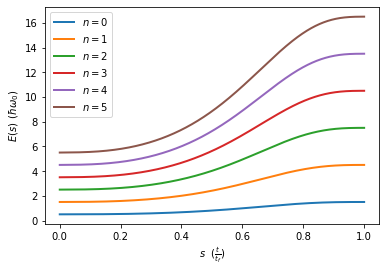

In [16]:
w_init=1.
w_fin=3.
tf=20.

def Energy(n,w):
    Energ=w*(n+0.5)
    return Energ

def freq_oscillator(s,w_init,w_fin,tf):
    gamma=np.sqrt(w_init/w_fin)
    coef_adia=6.*(gamma-1)*s**5 -15*(gamma-1)*s**4 +10*(gamma-1)*s**3 +1
    der_coef_adia=(6.*20*(gamma-1)*s**3 -15*12*(gamma-1)*s**2 +10*6*(gamma-1)*s)*(1/tf)**2
    frec_square=((w_init)**2/coef_adia**4)-(der_coef_adia/coef_adia)
    w_t=np.sqrt(frec_square)
    return w_t

energ0=[]
energ1=[]
energ2=[]
energ3=[]
energ4=[]
energ5=[]
energ6=[]

for s in s1:
    w=freq_oscillator(s,w_init,w_fin,tf)
    E0=Energy(0.,w)
    E1=Energy(1.,w)
    E2=Energy(2.,w)
    E3=Energy(3.,w)
    E4=Energy(4.,w)
    E5=Energy(5.,w)
    E6=Energy(6.,w)
    
    energ0.append(E0)
    energ1.append(E1)
    energ2.append(E2)
    energ3.append(E3)
    energ4.append(E4)
    energ5.append(E5)
    energ6.append(E6)
    
plt.figure(6)
plt.ylabel(r'$E(s) \:\: (\hbar \omega_{0})$')
plt.xlabel(r'$ s \:\:\: (\frac{t}{t_{f}}$)')
plt.plot(s1,energ0,linewidth=2,label=r"$n=0$")
plt.plot(s1,energ1,linewidth=2,label=r"$n=1$")
plt.plot(s1,energ2,linewidth=2,label=r"$n=2$")
plt.plot(s1,energ3,linewidth=2,label=r"$n=3$")
plt.plot(s1,energ4,linewidth=2,label=r"$n=4$")
plt.plot(s1,energ5,linewidth=2,label=r"$n=5$")
plt.legend()
plt.savefig('energy_cutoff.png')